In [1]:
#importation des données dvf géolocalisées en csv
!pip install -r requirements.txt
!pip install openpyxl
import os
import s3fs
import pandas as pd
from scripts import get_data
df = get_data.get_cloud_csv('dvf')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [folium]2m2/5 [openpyxl]


/home/onyxia/work/Python_2A/scripts/get_data.py:38: DtypeWarning: Columns (12,14,16,17,18,20,22,24,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [2]:
#On se limite aux maisons et appartements

df = df[df['type_local'].isin(['Maison', 'Appartement'])]
print(df)
df=df.reset_index()

          id_mutation date_mutation  numero_disposition nature_mutation  \
17             2020-6    2020-07-02                   1           Vente   
31             2020-8    2020-07-01                   1           Vente   
32             2020-9    2020-07-02                   1           Vente   
36            2020-11    2020-07-03                   1           Vente   
37            2020-12    2020-07-02                   1           Vente   
...               ...           ...                 ...             ...   
20102723  2025-502875    2025-06-23                   1           Vente   
20102725  2025-502876    2025-06-25                   1           Vente   
20102726  2025-502877    2025-06-25                   1           Vente   
20102734  2025-502880    2025-06-27                   1           Vente   
20102735  2025-502881    2025-06-27                   1           Vente   

          valeur_fonciere  adresse_numero adresse_suffixe  \
17                77000.0           34

In [3]:
comptage_df = df['id_mutation'].value_counts().reset_index()
comptage_df.columns = ['id_mutation', 'nombre_de_lignes']
print(comptage_df)

id_uniques = comptage_df[comptage_df['nombre_de_lignes'] == 1]
print(id_uniques.shape)

print(id_uniques)
df_sans_lots=df[df['id_mutation'].isin(id_uniques['id_mutation'])]
print(df_sans_lots)

         id_mutation  nombre_de_lignes
0        2021-687176              9290
1        2022-919567              7657
2        2022-909252              7477
3        2021-342324              7112
4        2020-491811              6173
...              ...               ...
4861632    2022-7412                 1
4861633    2022-7410                 1
4861634    2022-7409                 1
4861635    2022-7405                 1
4861636    2022-7419                 1

[4861637 rows x 2 columns]
(4133749, 2)
         id_mutation  nombre_de_lignes
727888   2023-581082                 1
727889   2023-510332                 1
727890   2023-580244                 1
727891   2023-510334                 1
727892   2023-579686                 1
...              ...               ...
4861632    2022-7412                 1
4861633    2022-7410                 1
4861634    2022-7409                 1
4861635    2022-7405                 1
4861636    2022-7419                 1

[4133749 rows x 2 colu

In [4]:
#les codes communes n'ont pas tous le même type ; certains sont des ints, d'autres des strings. On convertit l'ensemble en string pour plus de cohérence(on 
#ne peut pas faire l'opération inverse ; les codes corses commencent par 2A ou 2B !)

def inttostr(valeur):
    if isinstance(valeur, float):
        return str(valeur)
    if isinstance(valeur, int):
        return str(valeur)
    else:
        # Si c'est déjà une str, None, float, etc., on le retourne tel quel
        return valeur
print(inttostr('433'))

df.loc[:,'code_commune'] = df['code_commune'].apply(inttostr)
print(df['code_commune'])

433
0          01130
1          01451
2          01364
3          01053
4          01177
           ...  
6247210    75111
6247211    75112
6247212    75116
6247213    75113
6247214    75105
Name: code_commune, Length: 6247215, dtype: object


In [5]:
#Calcul du nombre de ventes commune

ventes_par_commune = df['code_commune'].value_counts().reset_index(name='nombre')

#Résultats : on remarque on particulier que Toulouse est la commune comptant le plus de ventes entre 2020 et 2025(50684) !!!

print(ventes_par_commune)

print( ventes_par_commune["nombre"][ventes_par_commune["code_commune"]=='2A004'])

print(ventes_par_commune['nombre'].max())

print(ventes_par_commune['nombre'].idxmax())

print(ventes_par_commune['code_commune'][ventes_par_commune['nombre'].idxmax()])

print(ventes_par_commune['nombre'][ventes_par_commune['nombre'].idxmax()])


      code_commune  nombre
0            31555   50684
1            06088   46697
2            44109   30331
3            33063   30077
4            34172   28927
...            ...     ...
33265        52549       1
33266        21136       1
33267        21653       1
33268        52053       1
33269        52505       1

[33270 rows x 2 columns]
145    4880
Name: nombre, dtype: int64
50684
0
31555
50684


In [6]:
#On récupère désormais les données de population ; cependant certaines valeurs ne sont pas renseignés. On remarque aussi que certaines communes ont des populations trop faibles
#pour que le ratio considéré ventes entre 2020 et 2050/population en 2019 ait du sens ; en particulier, la commune de Bezonvaux a zéro habitants !!! 
# On impose donc un nombre d'habitants minimum arbitraire, et on exclut les communes de populations trop faibles ou non renseignés

df_pop=pd.read_excel("popcommunes.xlsx")
df_pop.rename(columns={'codgeo': 'code_commune'}, inplace=True)
print(df_pop)

cols = ["p19_pop"]
df_pop[cols].isna().sum()
lignes_na = df_pop[df_pop[cols].isna().any(axis=1)]
print(lignes_na)
print(lignes_na.shape)

       objectid  reg dep    cv code_commune                 libgeo  p13_pop  \
0        115658   52  85  8502        85062            Châteauneuf    968.0   
1        115659   26  58  5808        58300                   Urzy   1839.0   
2        115660   43  70  7012        70137  Chassey-lès-Montbozon    218.0   
3        115661   21  51  5123        51649      Vitry-le-François  13174.0   
4        115662   11  78  7811        78638         Vaux-sur-Seine   4749.0   
...         ...  ...  ..   ...          ...                    ...      ...   
34990    110251   31  62  6225        62327         Febvin-Palfart    574.0   
34991    110252   73  12  1201        12156            Montpeyroux    550.0   
34992    110253   54  86  8610        86138                Luchapt    275.0   
34993    110254   72  33  3320        33184                Générac    579.0   
34994    110255   72  24  2409        24354       La Roche-Chalais   2932.0   

       p14_pop  p15_pop  p16_pop  p17_pop  p18_pop 

In [7]:
#Problème avec le fichier de données de population ; certains codes communes sont à six chiffres ! en effet dans les DOMS le numéro commence par un code département à trois chiffres plutôt qu'à deux(pour différencier les DOMs) !
#cela n'est pas un problème en soit mais la convention adoptée dans le fichier dvf est différente, on ne rajoute pas le troisième chiffre

#lignes à six chiffres

print(df_pop[df_pop['code_commune']=='974421'])
lignes_6_chiffres = df_pop[df_pop["code_commune"].str.len() == 6]
print(lignes_6_chiffres)

#code commune différent dans df_pop et df pour la commune de Salazie, à la Réunion ; 974421 dans df_pop, 97421 ; la Réunion est perçue comme le département
#974 dans df_pop, on va supprimer le 4

print(df_pop[df_pop['code_commune']=='974421']['libgeo'])
print(df[df['code_commune']=='97421']['nom_commune'])

      objectid  reg  dep     cv code_commune   libgeo  p13_pop  p14_pop  \
3786    131030    4  974  97406       974421  Salazie   7226.0   7132.0   

      p15_pop  p16_pop  p17_pop  p18_pop  p19_pop  p20_pop  p21_pop  
3786   7384.0   7400.0     7312   7224.0   7136.0   7310.0   7243.0  
       objectid  reg  dep     cv code_commune                  libgeo  \
84       126394    3  973    973       973353             Maripasoula   
192      126587    3  973    973       973313  Montsinéry-Tonnegrande   
206      126601    3  973    973       973358              Saint-Élie   
210      126605    1  971  97114       971102           Anse-Bertrand   
748      130678    1  971  97195       971106              Bouillante   
...         ...  ...  ...    ...          ...                     ...   
33141    115576    2  972    972       972225            Saint-Pierre   
33257    111336    4  974  97401       974404           L' Étang-Salé   
33557    111383    2  972    972       972201      L

In [8]:
#Pour remédier au problème précédent, il suffit de supprimer le troisième chiffre de chacun des codes communes à six chiffres.

def enleverchiffreDOMs(code):
    if len(code) == 6:
        # retirer le 3ème caractère (index 2)
        return code[:2] + code[3:]
    return code

# appliquer sur la colonne
df_pop["code_commune"] = df_pop["code_commune"].apply(enleverchiffreDOMs)

print(df_pop)
lignes_6_chiffres = df_pop[df_pop["code_commune"].str.len() == 6]
print(lignes_6_chiffres)
print(df_pop[df_pop['code_commune']=='974421'])

       objectid  reg dep    cv code_commune                 libgeo  p13_pop  \
0        115658   52  85  8502        85062            Châteauneuf    968.0   
1        115659   26  58  5808        58300                   Urzy   1839.0   
2        115660   43  70  7012        70137  Chassey-lès-Montbozon    218.0   
3        115661   21  51  5123        51649      Vitry-le-François  13174.0   
4        115662   11  78  7811        78638         Vaux-sur-Seine   4749.0   
...         ...  ...  ..   ...          ...                    ...      ...   
34990    110251   31  62  6225        62327         Febvin-Palfart    574.0   
34991    110252   73  12  1201        12156            Montpeyroux    550.0   
34992    110253   54  86  8610        86138                Luchapt    275.0   
34993    110254   72  33  3320        33184                Générac    579.0   
34994    110255   72  24  2409        24354       La Roche-Chalais   2932.0   

       p14_pop  p15_pop  p16_pop  p17_pop  p18_pop 

In [9]:
#On joint les données en se restreignant aux communes dont on connaît les populations et de populations pas trop faibles. Le min est arbitraire est peut être changé

ventes_par_commune_par_habitant=pd.merge(ventes_par_commune, df_pop, on='code_commune')
ventes_par_commune_par_habitant = ventes_par_commune_par_habitant[
    (ventes_par_commune_par_habitant['p19_pop'].notna()) &
    (ventes_par_commune_par_habitant['p19_pop'] > 1000)
]
ventes_par_commune_par_habitant['ventes par habitants par commune']=ventes_par_commune_par_habitant['nombre']/ventes_par_commune_par_habitant['p19_pop']

print(ventes_par_commune_par_habitant['ventes par habitants par commune'])

print(ventes_par_commune_par_habitant['ventes par habitants par commune'].max())

print(ventes_par_commune_par_habitant['ventes par habitants par commune'].idxmax())

print(ventes_par_commune_par_habitant['code_commune'][ventes_par_commune_par_habitant['ventes par habitants par commune'].idxmax()])

0        0.102710
1        0.136274
2        0.095139
3        0.115256
4        0.097878
           ...   
22363    0.014115
26593    0.015238
30690    0.005638
31746    0.000683
32063    0.000527
Name: ventes par habitants par commune, Length: 9422, dtype: float64
1.172281776416539
611
38191


In [10]:
#tentative de récupération des prix au m2
#Remarque : on ne considère que le ratio valeur foncière/surface batîe de la maison ou de l'appartement, puisqu'on ignore les dépendances ou autres terrains additionnels.
#on sur-estime donc la valeur au m2. On ignore les lots(on utilise df_sans_lots qui ne contient pas les observations dont l'id_mutation apparait plusieurs fois)
#à la fois parce qu'on ne peut pas retrouver la valeur foncière des éléments individuels, et pour se concentrer sur les logements anciens
df_sans_lots = df_sans_lots.copy()
print(df_sans_lots.shape)

df_sans_lots = df_sans_lots[
    (df_sans_lots['surface_reelle_bati'].notna()) &
    (df_sans_lots['valeur_fonciere'].notna()) &
    (df_sans_lots['surface_reelle_bati'] > 10)
]



df_sans_lots['rapport valeur foncière et surface bâtie']=df_sans_lots['valeur_fonciere']/df_sans_lots['surface_reelle_bati']

print(df_sans_lots['rapport valeur foncière et surface bâtie'])

print(df_sans_lots['rapport valeur foncière et surface bâtie'].max())

print(df_sans_lots['rapport valeur foncière et surface bâtie'].idxmax())

print(df_sans_lots.loc[df_sans_lots['rapport valeur foncière et surface bâtie'].idxmax()])

#problème ; valeurs monstrueuses de certains logements, visiblement des immeubles entiers plutôt que des logements(ci-dessus,immeuble en construction de presque 1 milliard...)


moyenne_par_commune=df_sans_lots.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()

print(moyenne_par_commune['rapport valeur foncière et surface bâtie'].max())

print(moyenne_par_commune['code_commune'].loc[moyenne_par_commune['rapport valeur foncière et surface bâtie'].idxmax()])



# Calcul de la médiane par commune
mediane_par_commune = df_sans_lots.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()

# Valeur maximale de la médiane
print(mediane_par_commune['rapport valeur foncière et surface bâtie'].max())

# Code de la commune avec la médiane maximale
print(mediane_par_commune['code_commune'][mediane_par_commune['rapport valeur foncière et surface bâtie'].idxmax()])

(4133749, 41)
0            669.565217
1           2286.885246
2           2220.625000
3           1966.406977
4           1666.666667
               ...     
6247210    11928.571429
6247211    11363.636364
6247212    14891.304348
6247213     9016.393443
6247214    11710.342553
Name: rapport valeur foncière et surface bâtie, Length: 4125604, dtype: float64
15937500.0
5816283
index                                                      18656556
id_mutation                                            2024-1198671
date_mutation                                            2024-06-27
numero_disposition                                                1
nature_mutation                                               Vente
valeur_fonciere                                         255000000.0
adresse_numero                                                 42.0
adresse_suffixe                                                 NaN
adresse_nom_voie                                       AV MONTAIGNE
adresse_cod

In [11]:
#meilleure alternative au troncage précédent ; on tronque par commune, on touve alors des médianes et moyennes très proches, maximale pour le sixième arrondissement parisien, c'est cohérent !

# Calculer les quantiles 0.025 et 0.975 par commune
quantiles_par_commune = (
    df_sans_lots
    .groupby('code_commune')['rapport valeur foncière et surface bâtie']
    .quantile([0.025, 0.975])
    .unstack()
    .reset_index()
    .rename(columns={0.025: 'quantile_025', 0.975: 'quantile_975'})
)

print(quantiles_par_commune)

# Fusionner les quantiles avec df_sans_lots
df_sans_lots_tronqué = df_sans_lots.merge(
    quantiles_par_commune,
    on='code_commune',
    how='left'
)

df_sans_lots_tronqué = df_sans_lots_tronqué[
    (df_sans_lots_tronqué['rapport valeur foncière et surface bâtie'] >= df_sans_lots_tronqué['quantile_025']) &
    (df_sans_lots_tronqué['rapport valeur foncière et surface bâtie'] <= df_sans_lots_tronqué['quantile_975'])
]

# Calcul de la moyenne par commune (tronqué)
moyenne_par_commune_tronqué = df_sans_lots_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()

# Affichage de la moyenne maximale et de la commune associée
print(moyenne_par_commune_tronqué['rapport valeur foncière et surface bâtie'].max())
print(moyenne_par_commune_tronqué['code_commune'].loc[moyenne_par_commune_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# Calcul de la médiane par commune (tronqué)
mediane_par_commune_tronqué = df_sans_lots_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()

# Affichage de la médiane maximale et de la commune associée
print(mediane_par_commune_tronqué['rapport valeur foncière et surface bâtie'].max())
print(mediane_par_commune_tronqué['code_commune'][mediane_par_commune_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

      code_commune  quantile_025  quantile_975
0            01001   1402.258065   4650.588503
1            01002    394.560643   3523.392756
2            01004   1017.798713   3943.055556
3            01005   1107.758621   4353.815194
4            01006    272.916667   2423.611111
...            ...           ...           ...
33081        97420    434.588798   4471.316033
33082        97421    191.712454   3174.025974
33083        97422    673.073579   5184.047619
33084        97423    177.530190   7281.037415
33085        97424    230.390338   5416.666667

[33086 rows x 3 columns]
14889.448668014387
75106
14752.04918032787
75106


In [12]:
import pandas

#On crée un dataframe complet contenant toutes les données pertinentes par commune 
#Attention : les données sur les ventes par habitant ont été crées plus tôt en se restreignant aux communes avec au moins un certain nombre d'ventes_par_commune_par_habitant_simple
#Remonter et changer de seuil si on veut élargir au restreindre le champ des données
#!!!Dans tous les cas il y aura pas mal de valeurs manquantes pour les données en question, bien faire gaffe à ce qu'on étudie!!!



pop_par_commune=df_pop[["code_commune", "p19_pop","libgeo"]]
ventes_par_commune_par_habitant_simple=ventes_par_commune_par_habitant[["code_commune", "ventes par habitants par commune"]]


df_final=pandas.merge(pop_par_commune, ventes_par_commune, how='outer', on="code_commune")
df_final.rename(columns={'nombre': 'nombre de ventes dans la commune'}, inplace=True)
df_final.rename(columns={'libgeo': 'nom de la commune'}, inplace=True)
df_final.rename(columns={'p19_pop': 'population en 2019'}, inplace=True)
df_final=pandas.merge(df_final, ventes_par_commune_par_habitant_simple, how='outer', on="code_commune")
df_final.rename(columns={'ventes par habitants par commune': 'nombre de ventes par habitant en 2019 dans la commune'}, inplace=True)
df_final=pandas.merge(df_final, mediane_par_commune_tronqué , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'médiane tronquée du prix au m2'}, inplace=True)
df_final=pandas.merge(df_final, moyenne_par_commune_tronqué , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'moyenne tronquée du prix au m2'}, inplace=True)
print(df_final)

print(df_final['moyenne tronquée du prix au m2'].max())
print(df_final['code_commune'][df_final['moyenne tronquée du prix au m2'].idxmax()])


      code_commune  population en 2019         nom de la commune  \
0            01001               779.0  L' Abergement-Clémenciat   
1            01002               256.0    L' Abergement-de-Varey   
2            01004             14134.0         Ambérieu-en-Bugey   
3            01005              1751.0       Ambérieux-en-Dombes   
4            01006               112.0                   Ambléon   
...            ...                 ...                       ...   
34995        97420             24065.0            Sainte-Suzanne   
34996        97421              7136.0                   Salazie   
34997        97422             79824.0                 Le Tampon   
34998        97423              7015.0         Les Trois-Bassins   
34999        97424              5538.0                    Cilaos   

       nombre de ventes dans la commune  \
0                                  59.0   
1                                  21.0   
2                                1280.0   
3          

In [13]:
df_final

,code_commune,population en 2019,nom de la commune,nombre de ventes dans la commune,nombre de ventes par habitant en 2019 dans la commune,médiane tronquée du prix au m2,moyenne tronquée du prix au m2
0,01001,779.0,L' Abergement-Clémenciat,59.0,NaN,2431.034483,2483.602665
1,01002,256.0,L' Abergement-de-Varey,21.0,NaN,1769.026549,1719.646511
2,01004,14134.0,Ambérieu-en-Bugey,1280.0,0.090562,2284.701114,2354.881148
3,01005,1751.0,Ambérieux-en-Dombes,235.0,0.134209,2812.820513,2803.968537
4,01006,112.0,Ambléon,16.0,NaN,1688.688525,1626.384067
...,...,...,...,...,...,...,...
34995,97420,24065.0,Sainte-Suzanne,1042.0,0.043299,2169.996032,2198.182140
34996,97421,7136.0,Salazie,228.0,0.031951,1458.185684,1396.345521
34997,97422,79824.0,Le Tampon,4277.0,0.053580,2228.571429,2393.514030
34998,97423,7015.0,Les Trois-Bassins,258.0,0.036778,2500.000000,3017.406091


In [14]:
commune_info= get_data.get_cloud_csv('dossier_complet',sep=';')

/home/onyxia/work/Python_2A/scripts/get_data.py:38: DtypeWarning: Columns (0,1701,1702) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [15]:
commune_info #Notez qu'il y a un problème avec CODGEO car il est lu comme un entier.

,CODGEO,P22_POP,P22_POP0014,P22_POP1529,P22_POP3044,P22_POP4559,P22_POP6074,P22_POP7589,P22_POP90P,P22_POPH,...,BPE_2024_C303,BPE_2024_C304,BPE_2024_C305,BPE_2024_D250,BPE_2024_D265,BPE_2024_D277,BPE_2024_D279,BPE_2024_D281,BPE_2024_D307,BPE_2024_F307
0,1001,859.0,162.000000,103.000000,157.000000,205.000000,156.000000,70.000000,6.000000,437.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002,273.0,57.000000,32.000000,58.000000,60.000000,43.000000,21.000000,2.000000,143.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004,15554.0,2992.348288,3161.190527,2998.287393,2661.947818,2365.246638,1179.551751,195.427586,7490.936208,...,0.0,0.0,0.0,12.0,25.0,15.0,26.0,33.0,4.0,1.0
3,1005,1917.0,362.644440,290.820926,389.153820,423.440841,310.850701,128.442123,11.647148,959.490308,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,1.0,1.0
4,1006,114.0,10.000000,14.000000,20.000000,24.000000,38.000000,8.000000,0.000000,60.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34983,80830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34984,85021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34985,85233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34986,88393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Pour corriger cela, nous allons lire comme une string et compléter avec 0 afin d'obtenir 
# un code commune à 5 chiffres.
commune_info['CODGEO'] = commune_info['CODGEO'].astype(str)
commune_info['CODGEO'] = commune_info['CODGEO'].str.zfill(5)
commune_info = commune_info.set_index('CODGEO')
#Nous avons défini codgeo comme index afin de faciliter la corrélation de cet ensemble 
# de données avec l'ensemble de données dvf.
commune_info

,P22_POP,P22_POP0014,P22_POP1529,P22_POP3044,P22_POP4559,P22_POP6074,P22_POP7589,P22_POP90P,P22_POPH,P22_H0014,...,BPE_2024_C303,BPE_2024_C304,BPE_2024_C305,BPE_2024_D250,BPE_2024_D265,BPE_2024_D277,BPE_2024_D279,BPE_2024_D281,BPE_2024_D307,BPE_2024_F307
CODGEO,,,,,,,,,,,,,,,,,,,,,
01001,859.0,162.000000,103.000000,157.000000,205.000000,156.000000,70.000000,6.000000,437.000000,95.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01002,273.0,57.000000,32.000000,58.000000,60.000000,43.000000,21.000000,2.000000,143.000000,27.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
01004,15554.0,2992.348288,3161.190527,2998.287393,2661.947818,2365.246638,1179.551751,195.427586,7490.936208,1531.743622,...,0.0,0.0,0.0,12.0,25.0,15.0,26.0,33.0,4.0,1.0
01005,1917.0,362.644440,290.820926,389.153820,423.440841,310.850701,128.442123,11.647148,959.490308,190.111646,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,1.0,1.0
01006,114.0,10.000000,14.000000,20.000000,24.000000,38.000000,8.000000,0.000000,60.000000,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#ici, nous avons une base de données qui explique chaque colonne de l'ensemble de données précédent
commune_meta_info = get_data.get_cloud_csv('meta_dossier_complet',sep=';') 
commune_meta_info

/home/onyxia/work/Python_2A/scripts/get_data.py:38: DtypeWarning: Columns (3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


,COD_VAR,LIB_VAR,LIB_VAR_LONG,COD_MOD,LIB_MOD,TYPE_VAR,LONG_VAR,THEME,SOURCE
0,P22_POP,Population en 2022 (princ),Population en 2022,NaN,NaN,NUM,16,Évolution et structure de la population,"Insee, RP2011, RP2016 et RP2022, géographie au..."
1,P22_POP0014,Pop 0-14 ans en 2022 (princ),Nombre de personnes de 0 à 14 ans en 2022,NaN,NaN,NUM,17,Évolution et structure de la population,"Insee, RP2011, RP2016 et RP2022, géographie au..."
2,P22_POP1529,Pop 15-29 ans en 2022 (princ),Nombre de personnes de 15 à 29 ans en 2022,NaN,NaN,NUM,17,Évolution et structure de la population,"Insee, RP2011, RP2016 et RP2022, géographie au..."
3,P22_POP3044,Pop 30-44 ans en 2022 (princ),Nombre de personnes de 30 à 44 ans en 2022,NaN,NaN,NUM,17,Évolution et structure de la population,"Insee, RP2011, RP2016 et RP2022, géographie au..."
4,P22_POP4559,Pop 45-59 ans en 2022 (princ),Nombre de personnes de 45 à 59 ans en 2022,NaN,NaN,NUM,17,Évolution et structure de la population,"Insee, RP2011, RP2016 et RP2022, géographie au..."
...,...,...,...,...,...,...,...,...,...
71810,CODGEO,Code géographique,Code du département suivi du numéro de commune...,75116,Paris 16e Arrondissement,CHAR,5,NaN,"Insee, COG au 01/01/2025"
71811,CODGEO,Code géographique,Code du département suivi du numéro de commune...,75117,Paris 17e Arrondissement,CHAR,5,NaN,"Insee, COG au 01/01/2025"
71812,CODGEO,Code géographique,Code du département suivi du numéro de commune...,75118,Paris 18e Arrondissement,CHAR,5,NaN,"Insee, COG au 01/01/2025"
71813,CODGEO,Code géographique,Code du département suivi du numéro de commune...,75119,Paris 19e Arrondissement,CHAR,5,NaN,"Insee, COG au 01/01/2025"


In [18]:
#nous allons imprimer une liste pour obtenir toutes ces informations
for i in commune_info.columns:
    lib = commune_meta_info.loc[commune_meta_info['COD_VAR'] == i, 'LIB_VAR_LONG'].values
    if lib.size > 0:
        print(f"{i} {lib[0]}")
    else:
        print(f"{i} errror")

P22_POP Population en 2022
P22_POP0014 Nombre de personnes de 0 à 14 ans en 2022
P22_POP1529 Nombre de personnes de 15 à 29 ans en 2022
P22_POP3044 Nombre de personnes de 30 à 44 ans en 2022
P22_POP4559 Nombre de personnes de 45 à 59 ans en 2022
P22_POP6074 Nombre de personnes de 60 à 74 ans en 2022
P22_POP7589 Nombre de personnes de 75 à 89 ans en 2022
P22_POP90P Nombre de personnes de 90 ans ou plus en 2022
P22_POPH Nombre total d'hommes en 2022
P22_H0014 Nombre d'hommes de 0 à 14 ans en 2022
P22_H1529 Nombre d'hommes de 15 à 29 ans en 2022
P22_H3044 Nombre d'hommes de 30 à 44 ans en 2022
P22_H4559 Nombre d'hommes de 45 à 59 ans en 2022
P22_H6074 Nombre d'hommes de 60 à 74 ans en 2022
P22_H7589 Nombre d'hommes de 75 à 89 ans en 2022
P22_H90P Nombre d'hommes de 90 ans ou plus en 2022
P22_H0019 Nombre d'hommes de 0 à 19 ans en 2022
P22_H2064 Nombre d'hommes de 20 à 64 ans en 2022
P22_H65P Nombre d'hommes de 65 ans ou plus en 2022
P22_POPF Nombre total de femmes en 2022
P22_F0014 Nombre

In [19]:
#Nous allons maintenant imprimer le nombre de NaN que nous avons pour chaque colonne afin de voir combien 
# d'informations nous perdons en utilisant cette colonne comme variable explicative.
for col in commune_info.columns:
    n_nan = commune_info[col].isna().sum()  
    print(f"{col} - {n_nan}")

P22_POP - 89
P22_POP0014 - 89
P22_POP1529 - 89
P22_POP3044 - 89
P22_POP4559 - 89
P22_POP6074 - 89
P22_POP7589 - 89
P22_POP90P - 89
P22_POPH - 89
P22_H0014 - 89
P22_H1529 - 89
P22_H3044 - 89
P22_H4559 - 89
P22_H6074 - 89
P22_H7589 - 89
P22_H90P - 89
P22_H0019 - 89
P22_H2064 - 89
P22_H65P - 89
P22_POPF - 89
P22_F0014 - 89
P22_F1529 - 89
P22_F3044 - 89
P22_F4559 - 89
P22_F6074 - 89
P22_F7589 - 89
P22_F90P - 89
P22_F0019 - 89
P22_F2064 - 89
P22_F65P - 89
P22_POP01P - 89
P22_POP01P_IRAN1 - 89
P22_POP01P_IRAN2 - 89
P22_POP01P_IRAN3 - 89
P22_POP01P_IRAN4 - 89
P22_POP01P_IRAN5 - 89
P22_POP01P_IRAN6 - 89
P22_POP01P_IRAN7 - 89
P22_POP0114_IRAN2P - 89
P22_POP0114_IRAN2 - 89
P22_POP0114_IRAN3P - 89
P22_POP1524_IRAN2P - 89
P22_POP1524_IRAN2 - 89
P22_POP1524_IRAN3P - 89
P22_POP2554_IRAN2P - 89
P22_POP2554_IRAN2 - 89
P22_POP2554_IRAN3P - 89
P22_POP55P_IRAN2P - 89
P22_POP55P_IRAN2 - 89
P22_POP55P_IRAN3P - 89
C22_POP15P - 89
C22_POP15P_STAT_GSEC11_21 - 89
C22_POP15P_STAT_GSEC12_22 - 89
C22_POP15P_STAT_

P16_POP01P - 93
P16_POP01P_IRAN1 - 93
P16_POP01P_IRAN2 - 93
P16_POP01P_IRAN3 - 93
P16_POP01P_IRAN4 - 93
P16_POP01P_IRAN5 - 93
P16_POP01P_IRAN6 - 93
P16_POP01P_IRAN7 - 93
P16_POP0114_IRAN2P - 93
P16_POP0114_IRAN2 - 93
P16_POP0114_IRAN3P - 93
P16_POP1524_IRAN2P - 93
P16_POP1524_IRAN2 - 93
P16_POP1524_IRAN3P - 93
P16_POP2554_IRAN2P - 93
P16_POP2554_IRAN2 - 93
P16_POP2554_IRAN3P - 93
P16_POP55P_IRAN2P - 93
P16_POP55P_IRAN2 - 93
P16_POP55P_IRAN3P - 93
C16_POP15P - 93
C16_POP15P_CS1 - 93
C16_POP15P_CS2 - 93
C16_POP15P_CS3 - 93
C16_POP15P_CS4 - 93
C16_POP15P_CS5 - 93
C16_POP15P_CS6 - 93
C16_H15P - 93
C16_H15P_CS1 - 93
C16_H15P_CS2 - 93
C16_H15P_CS3 - 93
C16_H15P_CS4 - 93
C16_H15P_CS5 - 93
C16_H15P_CS6 - 93
C16_F15P - 93
C16_F15P_CS1 - 93
C16_F15P_CS2 - 93
C16_F15P_CS3 - 93
C16_F15P_CS4 - 93
C16_F15P_CS5 - 93
C16_F15P_CS6 - 93
C16_POP1524 - 93
C16_POP1524_CS1 - 93
C16_POP1524_CS2 - 93
C16_POP1524_CS3 - 93
C16_POP1524_CS4 - 93
C16_POP1524_CS5 - 93
C16_POP1524_CS6 - 93
C16_POP2554 - 93
C16_POP25

In [20]:
#nous définissons également l'index de df_final comme le code commune
df_final = df_final.set_index('code_commune')
df_final

,population en 2019,nom de la commune,nombre de ventes dans la commune,nombre de ventes par habitant en 2019 dans la commune,médiane tronquée du prix au m2,moyenne tronquée du prix au m2
code_commune,,,,,,
01001,779.0,L' Abergement-Clémenciat,59.0,NaN,2431.034483,2483.602665
01002,256.0,L' Abergement-de-Varey,21.0,NaN,1769.026549,1719.646511
01004,14134.0,Ambérieu-en-Bugey,1280.0,0.090562,2284.701114,2354.881148
01005,1751.0,Ambérieux-en-Dombes,235.0,0.134209,2812.820513,2803.968537
01006,112.0,Ambléon,16.0,NaN,1688.688525,1626.384067
...,...,...,...,...,...,...
97420,24065.0,Sainte-Suzanne,1042.0,0.043299,2169.996032,2198.182140
97421,7136.0,Salazie,228.0,0.031951,1458.185684,1396.345521
97422,79824.0,Le Tampon,4277.0,0.053580,2228.571429,2393.514030


In [21]:
from scripts import global_variables

In [22]:
from scripts import global_variables
from scripts.data_clean import *
from scripts.global_variables import var_explicative_appartment


X_appartment = prepare_regression_dataset(commune_info,var_explicative_appartment) 

In [23]:
#Nous filtrons uniquement les colonnes que nous allons utiliser dans la régression des appartements.
X_appartment 


,P22_APPART,P22_LOGVAC,P22_RSECOCC,P22_RP_1P,P22_RPAPPART_ACH2019,P22_RPAPPART_ACH1919,P22_POP2539,P22_POP4054,C22_MENPSEUL,C22_PMEN,P22_MEN_ANEM0002,C22_POP15P_STAT_GSEC13_23
CODGEO,,,,,,,,,,,,
01001,9.000000,14.000000,11.000000,0.000000,2.000000,0.000000,151.000000,177.000000,73.628571,859.000000,37.000000,73.628571
01002,2.000000,13.000000,41.000000,1.000000,0.000000,0.000000,41.000000,74.000000,39.709091,273.000000,7.000000,19.854545
01004,4311.645230,741.215108,125.143124,331.468500,1076.773758,112.911234,3099.339484,2753.287276,2887.872092,15061.008969,1043.846787,983.205730
01005,243.719043,98.535293,7.749967,7.085156,107.877514,25.499476,389.045273,400.780251,218.500246,1917.000000,106.941043,135.089600
01006,3.000000,6.000000,8.000000,0.000000,0.000000,0.000000,22.000000,18.000000,15.545455,114.000000,8.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
97420,2410.355206,570.258138,59.340542,144.693391,710.439189,7.345810,4418.694698,5248.022706,2142.167782,24754.717596,1020.888878,947.418529
97421,68.105176,494.375505,212.178329,25.728263,11.773051,0.000000,1295.297747,1567.332570,711.278846,7330.374496,298.623635,61.700211
97422,8894.683363,2191.282801,1120.385408,2067.699346,2381.282900,18.679559,14640.915939,15820.512974,10824.878294,81450.668697,4592.081714,2590.061227


In [24]:
#nous sélectionnons uniquement la colonne contenant le prix au m² qui sera notre variable expliquée
prix_m2_appartment  = df_final['moyenne tronquée du prix au m2'].dropna() 
prix_m2_appartment

code_commune
01001    2483.602665
01002    1719.646511
01004    2354.881148
01005    2803.968537
01006    1626.384067
            ...     
97420    2198.182140
97421    1396.345521
97422    2393.514030
97423    3017.406091
97424    1768.829934
Name: moyenne tronquée du prix au m2, Length: 32306, dtype: float64

In [25]:
from scripts.do_ols import run_log_ols_regression

In [26]:
model = run_log_ols_regression(prix_m2_appartment, X_appartment)
print(model.summary())

                                  OLS Regression Results                                  
Dep. Variable:     moyenne tronquée du prix au m2   R-squared:                       0.170
Model:                                        OLS   Adj. R-squared:                  0.169
Method:                             Least Squares   F-statistic:                     548.0
Date:                            Sun, 28 Dec 2025   Prob (F-statistic):               0.00
Time:                                    17:15:03   Log-Likelihood:                -19960.
No. Observations:                           32211   AIC:                         3.995e+04
Df Residuals:                               32198   BIC:                         4.006e+04
Df Model:                                      12                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

In [27]:
from scripts.getvis import plot_log_ols_regression

Info: 529 valeurs extrêmes retirées pour une meilleure visualisation


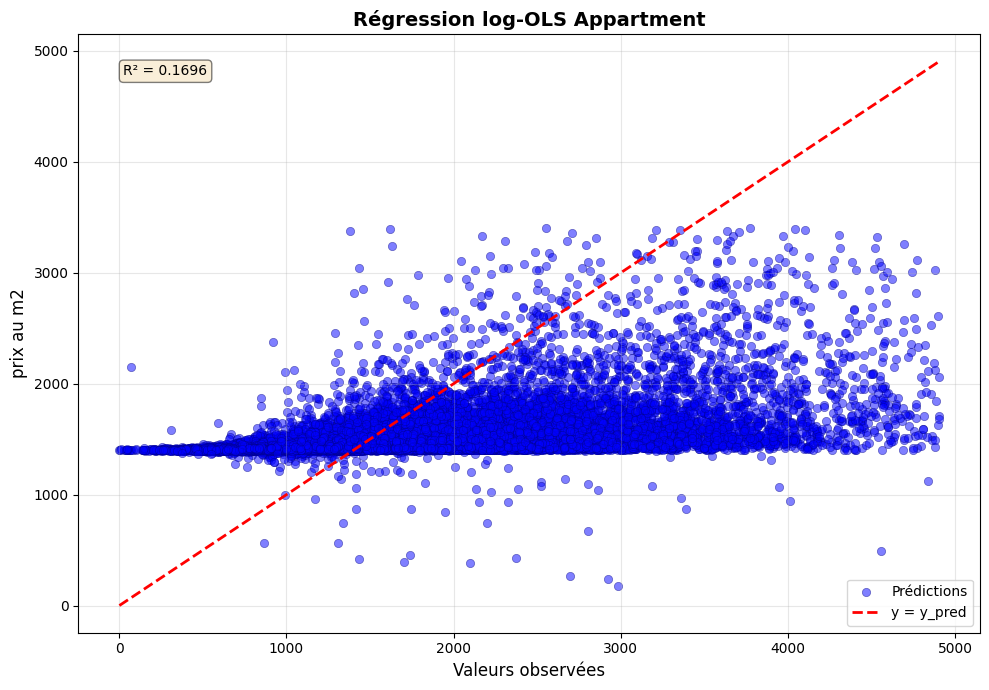

{'n_total': 32211,
 'n_plotted': 31682,
 'y_max': np.float64(14889.448668014387),
 'y_pred_max': np.float64(843196.9624540755)}

In [28]:
plot_log_ols_regression(model,prix_m2_appartment,X_appartment,title='Régression log-OLS Appartment')

In [29]:
# Dans ce cas, nous avons effectué une régression du prix au m² des appartements à partir de 12 variables explicatives, à savoir :
#- Nombre d'appartements en 2022
#- Nombre de logements vacants en 2022
#- Nombre de résidences secondaires et logements occasionnels en 2022
#- Nombre de résidences principales d'1 pièce en 2022
#-Nombre de résidences principales de type appartement construites
#de 2006 à 2019 en 2022
#- Nombre de résidences principales de type appartement construites
#avant 1919 en 2022
#- Nombre de personnes de 25 à 39 ans vivant en couple en 2022
#- Nombre de personnes de 40 à 54 ans en 2022
#- Nombre de ménages d'une personne en 2022
#- Nombre de personnes des ménages en 2022
#- Nombre de ménages ayant emménagé depuis moins de 2 ans en 2022
#- Nombre de personnes de 15 ans ou plus Cadres et Professions
# intellectuelles supérieures en 2022